In [ ]:
import numpy as np
import random

import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from flax import linen as nn

In [12]:
# Generate 100 sine functions with different a,b,c parameters and random noise
def sine(a,b,c,x):
    return a * np.sin(b * x + c)

x_data = np.arange(0,10,0.001)
a_list = np.linspace(0,10,100)
b_list = np.linspace(0.1,6,100)
c_list = np.linspace(0,5,100)

my_a = random.choice(a_list)
my_b = random.choice(b_list)
my_c = random.choice(c_list)

y_data = sine(my_a, my_b, my_c, x_data) + my_a * np.random.rand(len(x_data))

In [13]:
n_params = 3

class DenseClassifier(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_params)(x)
        return x

In [18]:
dummy_input = jnp.ones((1, len(x_data)))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs          ┃ outputs       ┃ params         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,1000… │ float32[1,3]  │                │
├─────────┼─────────────────┼─────────────────┼───────────────┼────────────────┤
│ Dense_0 │ Dense           │ float32[1,1000… │ float32[1,10] │ bias:          │
│         │                 │                 │               │ float32[10]    │
│         │                 │                 │               │ kernel:        │
│         │                 │                 │               │ float32[10000… │
│         │                 │                 │               │                │
│         │                 │                 │               │ 100,010 (400.0 │
│         │                

In [14]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [19]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [20]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [21]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [22]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [23]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [24]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [25]:
n_epochs = 50

In [26]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(x_data, y_data):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      #test_state = state
      #test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      #for metric,value in test_state.metrics.compute().items():
      #  metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      #print(f"test epoch: {(step+1) // n_batches}, "
      #      f"loss: {metrics_history['test_loss'][-1]}, "
      #      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

IndexError: tuple index out of range

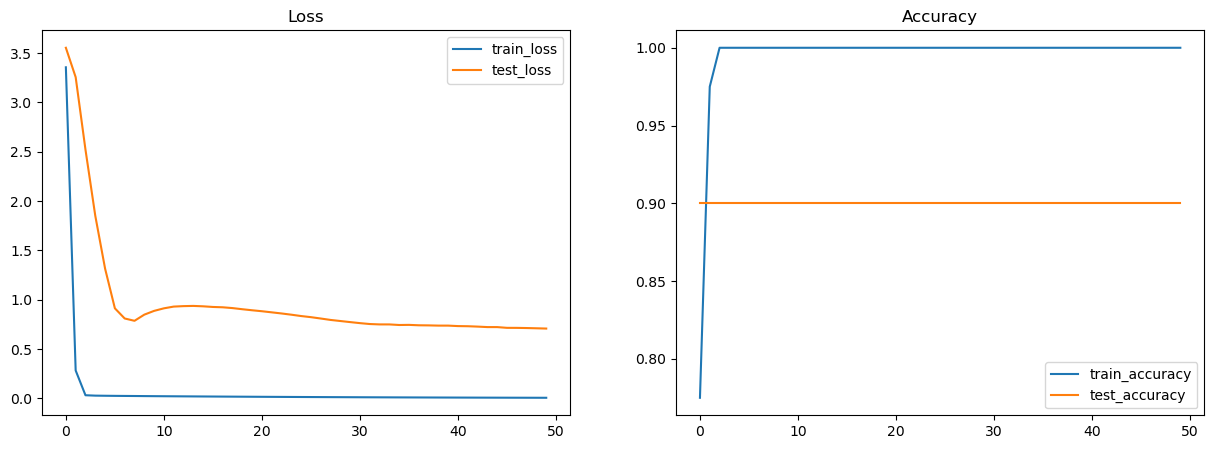

<Figure size 640x480 with 0 Axes>

In [276]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

# 2: Is your trained model confident that any of the stars in your test set are part of M4?

Yes, as seen above, my model is very confident that many of the stars are in M4, since there is a large spike at 4 on the plot above.

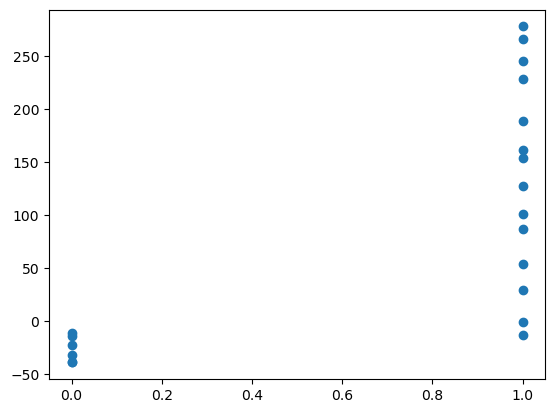

In [279]:
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.scatter(df[test_sel]['signal'], jnp.diff(outputs, axis=1))

In [ ]:
confident_pos = jnp.where(jnp.diff(outputs, axis=1) > 0)[0]
confident_df = df[test_sel].iloc[confident_pos]
confident_df

,0.0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009000000000000001,...,9.991,9.992,9.993,9.994,9.995000000000001,9.996,9.997,9.998,9.999,signal
78,-7.235207,-11.968123,-6.731970,-17.975808,-2.803832,-8.607543,1.056745,-2.250327,1.262938,-2.726429,...,2.022821,-2.321794,-13.305827,-18.628868,7.316213,-2.249143,-6.308843,-5.297203,-0.855735,0
56,-18.996223,-13.023505,-3.686150,-0.205909,-6.050872,-10.015712,-3.996222,-9.337368,-16.974998,-12.394853,...,-7.897099,-10.601741,-10.802196,1.229697,-25.474569,-4.787764,-3.998023,-8.705748,-14.831099,1
28,-0.652847,-1.487352,2.283883,-0.206217,-0.071652,0.574225,3.037637,-0.103876,-2.782324,-3.278238,...,-3.102130,-1.096779,-4.293513,-5.243015,4.174022,-4.910047,0.271354,2.591514,-1.171797,1
0,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1
55,-8.474528,-13.147137,-10.112113,-27.308254,-5.909668,-6.263365,-12.267611,-6.899533,-5.795775,-21.035743,...,-13.886557,-3.444071,-2.490787,-14.582159,-8.875022,-15.571605,-12.019953,-14.581872,-6.617707,1


In [280]:
confident_neg = jnp.where(jnp.diff(outputs, axis=1) < 0)[0]
confident_ndf = df[test_sel].iloc[confident_neg]
confident_ndf

,0.0,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009000000000000001,...,9.991,9.992,9.993,9.994,9.995000000000001,9.996,9.997,9.998,9.999,signal
53,-12.133916,3.883980,6.039469,-3.778882,-1.867341,-11.977664,-4.606391,-3.305908,-3.601083,-5.073379,...,-13.275146,-6.779815,-4.883777,-2.853155,-7.517380,7.162873,-2.332073,-6.070077,-5.858948,1
61,-15.142265,-3.575813,-15.366209,-9.322454,-11.641253,-8.959156,-9.233774,-6.300474,-5.582496,-9.974801,...,-13.085366,-14.377038,1.240355,-12.909719,-8.156240,-3.852461,-3.044475,1.231295,-6.649533,0
98,-7.478163,-13.041837,-14.562350,-1.994539,2.986645,-3.760593,-15.867209,2.100777,-19.966831,11.729417,...,-4.287854,-13.460582,-9.879062,-18.829803,2.357227,14.978663,-12.164367,-17.676469,-8.923713,0
58,-4.094111,-0.602149,-4.328792,-14.125545,-1.738637,-9.092070,-6.853080,-3.728208,-2.152176,9.523230,...,-16.231368,-11.295010,-3.287798,-20.964945,-13.663820,-5.810588,-10.704594,-13.772686,-7.249210,1
97,0.260439,-16.976492,-15.510339,-0.843809,-12.183628,-19.296717,-20.260168,-11.223108,-31.968494,22.487613,...,-8.032344,-3.628334,-0.158841,-19.238269,-24.335984,4.583351,-15.839707,1.147958,1.850976,0
67,0.433114,-12.835070,-7.110802,10.694414,-8.672133,-0.525351,-1.703403,-12.618164,-9.324020,-0.986201,...,5.717842,-3.392300,3.106134,-3.549336,-9.074593,3.725586,-8.474995,-9.927899,3.675254,0
90,0.011755,-11.797884,-9.703984,-4.814897,-14.654308,-11.913927,-5.184471,-20.251220,-16.175140,-5.447179,...,-7.705731,0.268823,-20.518819,4.974038,-6.941894,6.467304,-2.421684,-14.690432,-13.524489,0
76,-1.020322,2.669190,-6.472731,-3.706253,-5.249861,-18.617756,-0.404879,-3.347678,-8.549068,5.220438,...,-12.726343,-5.251344,1.005303,0.162501,-4.209576,-6.298885,-18.554669,-14.970262,-15.814227,0
